In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices



from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import (StandardScaler,
                                   LabelEncoder,
                                   OneHotEncoder)
from sklearn.model_selection import (train_test_split,
                                     KFold,
                                     LeaveOneOut,
                                     ShuffleSplit,
                                     cross_validate,
                                     GridSearchCV)
from sklearn.metrics import (accuracy_score,
                             mean_squared_error,
                             confusion_matrix,
                             classification_report)
from sklearn.pipeline import Pipeline

#Getting Started

**The Goal of this Analysis is to analyze the impact of lifestyle factors on sleep quality.**

Before starting, let's outline some general steps to help understand and clean the dataset. The more we can visualize, the easier it will be to intuitively understand the relationships between our data.


##Load and Inspect the Data

In [ ]:
Sleep = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv", index_col = "Person ID")
Sleep.head() #gives the first 5 rows of the dataset

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
Person ID,,,,,,,,,,,,
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [ ]:
Sleep.describe() #returns basic statistics about the data

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


Wow, that's a lot of numbers, and it can be very jarring trying to figure out what information I can make from it.

Let's try to understand what this data is telling us. Each column header corresponds to features, or columns, in the dataset.
The rows tell us certain attributes about each column:
 - **count** - represents the number of non-missing entries in each column.
 - **mean** - represents the average value
 - **std** - measures the standard deviation around the mean
 - **min, max** - gives us minimum and maximum value
 - **25%, 50%, 75%** - gives us the values of the first, second and third quartiles. The first Quartile (Q1) tells us the value below which 25% of the obersvations fall. It follows that Q2 is the median.


 *Note: The Quartiles (Q1 and Q3) can help you understand the spread of data to identify potential outliers. The interquartile range (IQR), defined as Q3 - Q1, represents the middle 50% of the data.*


The Acute among you may have noticed that some of the columns are missing compared to when we called the `Sleep.head()` method that returns the first 5 entries in the dataset. This is because `Sleep.describe()` will only select only variables that are formatted as numbers. If we want a summary of non-numeric columns we can call `Sleep.describe(include= 'all')`

Knowing this, lets take a look at the datatype for each column.

In [ ]:
Sleep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374 entries, 1 to 374
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   374 non-null    object 
 1   Age                      374 non-null    int64  
 2   Occupation               374 non-null    object 
 3   Sleep Duration           374 non-null    float64
 4   Quality of Sleep         374 non-null    int64  
 5   Physical Activity Level  374 non-null    int64  
 6   Stress Level             374 non-null    int64  
 7   BMI Category             374 non-null    object 
 8   Blood Pressure           374 non-null    object 
 9   Heart Rate               374 non-null    int64  
 10  Daily Steps              374 non-null    int64  
 11  Sleep Disorder           374 non-null    object 
dtypes: float64(1), int64(6), object(5)
memory usage: 38.0+ KB


Everything looks good, except for blood pressure. Even though it is numeric, the formatting "int/int" caused it to be a string. Let's fix this.

In [ ]:
bp_split = [s.split("/") for s in Sleep["Blood Pressure"]]
for i in range(len(bp_split)):
  bp_split[i] = [int(bp_split[i][j]) for j in [0, 1]]
systolic_bp = [bp[0] for bp in bp_split]
diastolic_bp = [bp[1] for bp in bp_split]
Sleep["Systolic BP"] = systolic_bp
Sleep["Diastolic BP"] = diastolic_bp

Sleep = Sleep.drop(columns = ["Blood Pressure"])

In [ ]:
Sleep.columns

Index(['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep',
       'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate',
       'Daily Steps', 'Sleep Disorder', 'Systolic BP', 'Diastolic BP'],
      dtype='object')

Now we can do some quick visualizations to see how some categories relate to eachother. We use a bar plot to show the relationship between a categorical variable and a continuous variable.

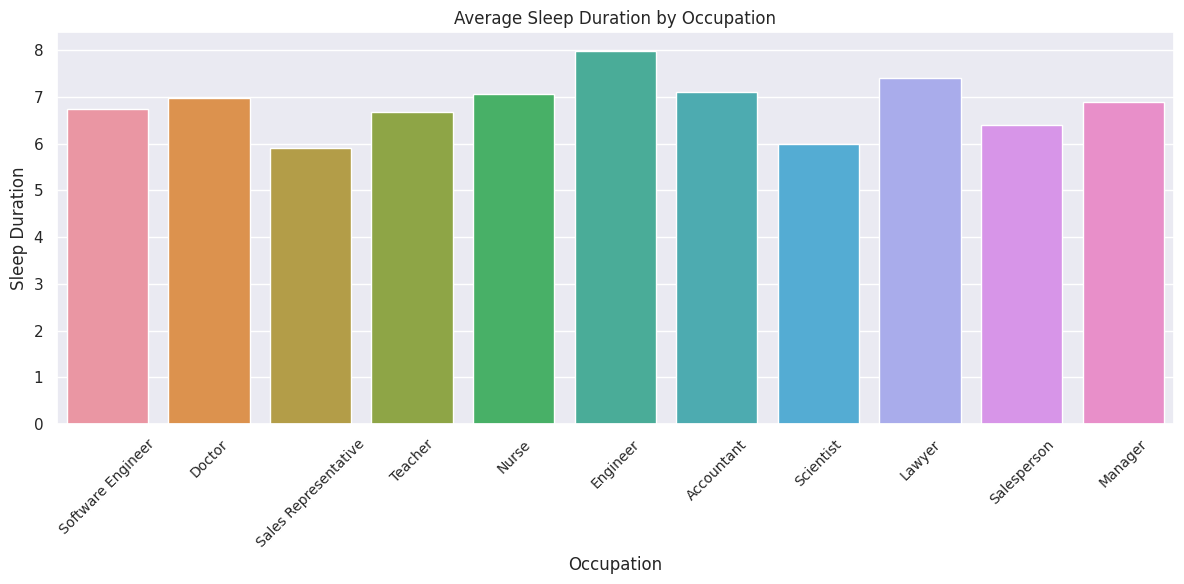

In [ ]:
sns.set_theme(style = "darkgrid")
plt.figure(figsize = (12, 6))
sns.barplot(x = "Occupation", y = "Sleep Duration", data = Sleep, errorbar = None)
plt.title("Average Sleep Duration by Occupation")
plt.xticks(rotation = 45, fontsize = 10)
plt.tight_layout();

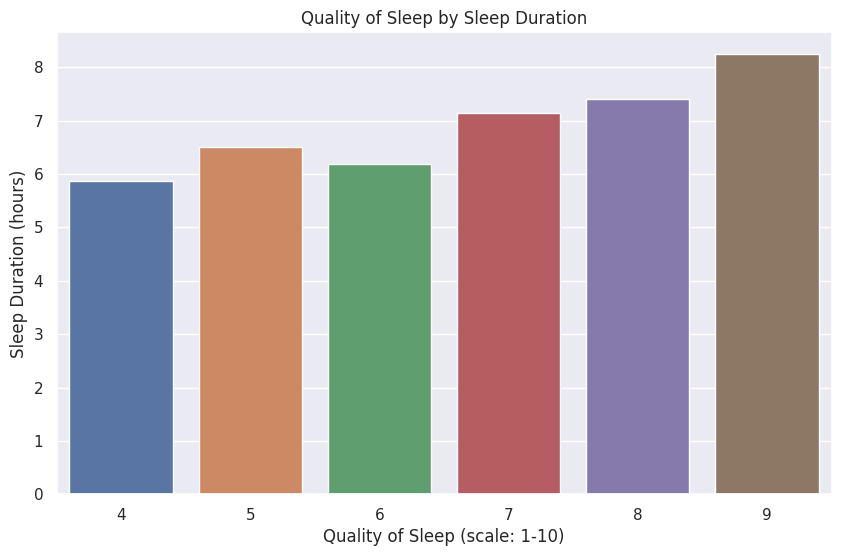

In [ ]:
plt.figure(figsize = (10,6))
sns.barplot(x = "Quality of Sleep",
             y = "Sleep Duration",
             data = Sleep,
            errorbar = None)
plt.title("Quality of Sleep by Sleep Duration")
plt.xlabel("Quality of Sleep (scale: 1-10)")
plt.ylabel("Sleep Duration (hours)");


It looks like **engineers**, on average, get the most sleep, with **sales representatives** and  **scientists** getting the least amount. However, without knowing the distribution of each class, we cant be sure of how fair this metric is.

Intutively, it makes sense that one's quality of sleep would be proportional to Sleep Duration.

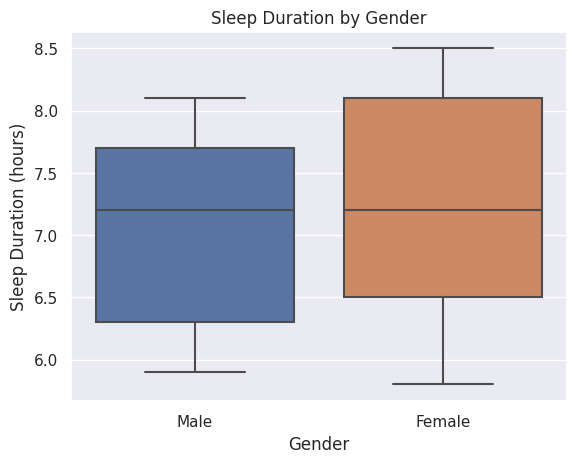

In [ ]:
sns.boxplot(x = "Gender", y = "Sleep Duration", data = Sleep)
plt.ylabel("Sleep Duration (hours)")
plt.title("Sleep Duration by Gender");

This box plot displays the distribution of sleep duration for both males and females. The boxes represent the inter quartile range(IQR), showing the middle 50% of the data, with the whiskers extending out to the minimum and maximum values within 1.5 times the IQR. Any points outside of this range are considered potential outliers.

### Numerical

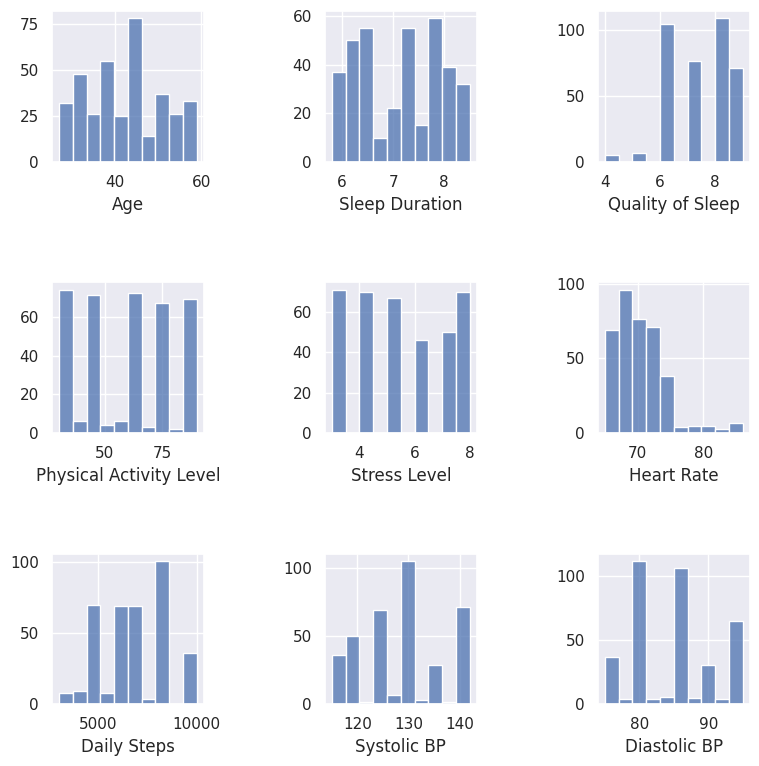

In [ ]:
fig, axs = plt.subplots(3,3, figsize = (9,9))
plt.subplots_adjust(wspace = 0.8, hspace = 0.8)
numeric = ["Age", "Sleep Duration", "Quality of Sleep",
           "Physical Activity Level", "Stress Level", "Heart Rate",
           "Daily Steps", "Systolic BP", "Diastolic BP"]
for idx, cat in enumerate(numeric):
  sns.histplot(Sleep[cat], bins = 10, ax = axs[int(idx/3)][idx % 3])
  axs[int(idx/3)][idx % 3].set_ylabel("")

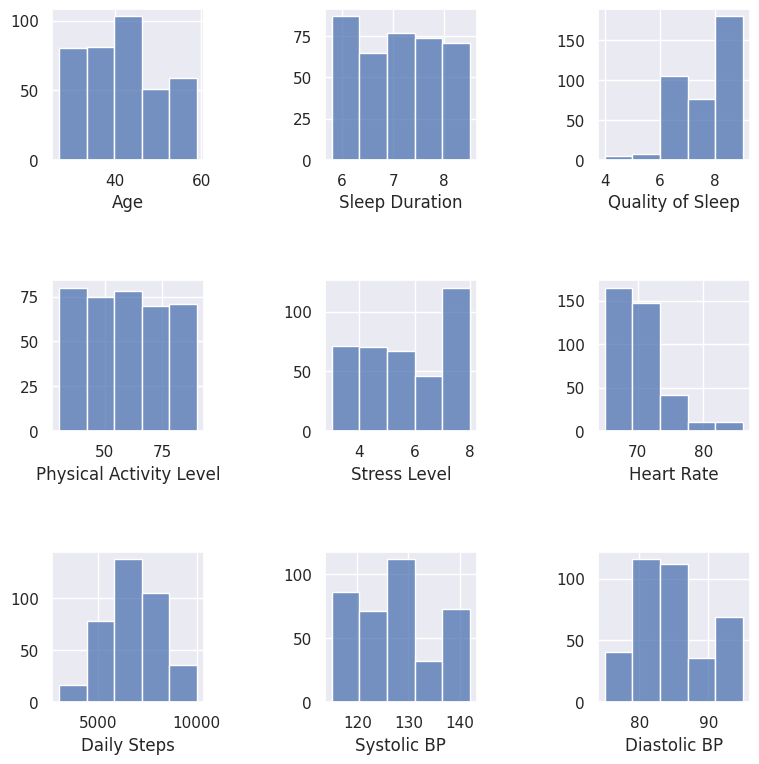

In [ ]:
fig, axs = plt.subplots(3,3, figsize = (9,9))
plt.subplots_adjust(wspace = 0.8, hspace = 0.8)
for idx, cat in enumerate(numeric):
  sns.histplot(Sleep[cat], bins = 5, ax = axs[int(idx/3)][idx % 3])
  axs[int(idx/3)][idx % 3].set_ylabel("")

Some interesting takeaways:
 - **Sleep Duration** and **Physcial Activity Level** tend to all be uniformly distrubted.
 - **Age** and **Daily Steps** seem to be somewhat normally distributed.
 - **Stress Level**, **Quality of Sleep** and **Heart Rate** tend to all be skewed in one direction.
 - **Systolic BP** and **Diastolic BP** do not appear to have the same type distribution, which needs further explanation.


 One thing to note are some patterns we see with quite a few of the categories are spaced out, the reason being we do not know. We may want to keep an eye out for potential issues that can arise from this. However, it does appear that there are no apprent outliers, and most of the parameters do seem intuitively related to sleep quality.

###Categorical

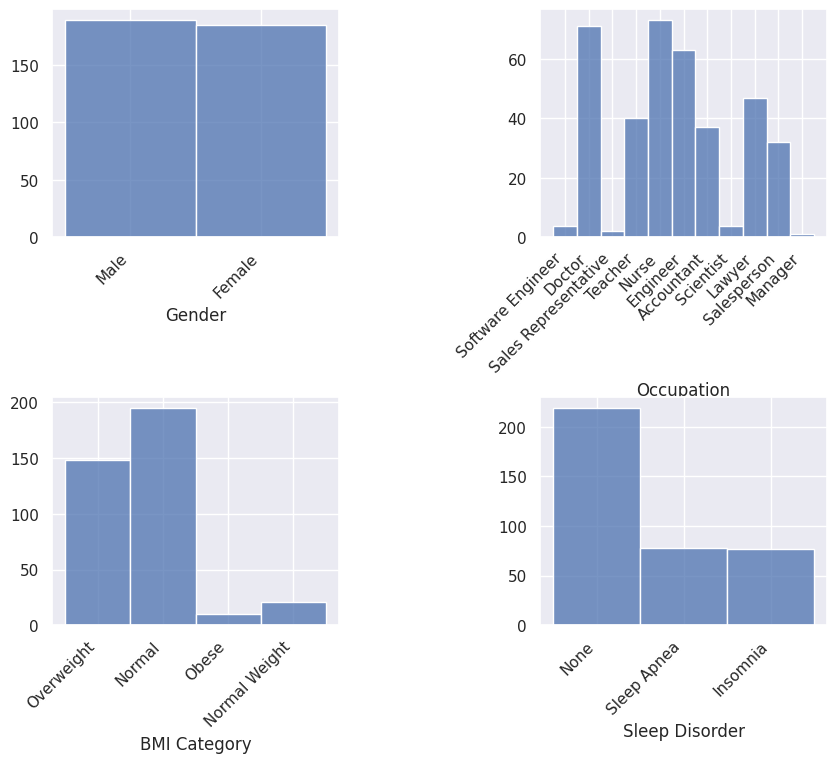

In [ ]:
fig, axs = plt.subplots(2,2, figsize = (10,8))
plt.subplots_adjust(wspace = 0.7, hspace = 0.7)

Categorical = ["Gender", "Occupation", "BMI Category", "Sleep Disorder"]
for idx, cat in enumerate(Categorical):
  ax = sns.histplot(Sleep[cat], ax = axs[int(idx/2), idx %2])
  ax.set_ylabel('')
  plt.setp(ax.get_xticklabels(), rotation = 45, ha="right", va = "top")



Looking at our categorical variables, there are some things to note:

- **Gender**: Male and Female seem to be evenly distributed
- **Occupation**: Certain occupations, do not have sufficeint rpresentation to draw any conclusions. Since there are multiple classes that dont have a strong representation, we can group these all together into an **"other"** class.
  - When we made the assumption that **sales representatives** and **scientists** got the least amount of sleep, there were actually only a couple of these occupations in the dataset, which is not nearly enough data to make any conclusions.
- **BMI Category** - There seems to no discrepency between "Normal" and "Normal Weight" classes. Let's combine these two. Aside from that, there seems to be arelatively even distribution between Normal BMI and Overweight+ BMI.
- **Sleep Disorder**: the distribution is split among those that have no sleeping disorder, and those that suffer from leep apnea and insomnia. We may choose this as our response variable.

In [ ]:
Sleep["BMI Category"] = Sleep["BMI Category"].replace(to_replace = "Normal Weight", value="Normal")

In [ ]:
counts = Sleep["Occupation"].value_counts()
under_20_bool = (counts < 20)
under_20 = [counts.index.to_list()[i] for i in range(len(counts)) if under_20_bool.values[i]]
Sleep["Occupation"] = Sleep["Occupation"].replace(to_replace = under_20, value = "Other")

In [ ]:
Sleep["BMI Category"].value_counts()

Normal        216
Overweight    148
Obese          10
Name: BMI Category, dtype: int64

In [ ]:
Sleep["Occupation"].value_counts()

Nurse          73
Doctor         71
Engineer       63
Lawyer         47
Teacher        40
Accountant     37
Salesperson    32
Other          11
Name: Occupation, dtype: int64

Let's take a look at a heatmap that compares the correlation between each variable. *Its important to note that this is will only pick up on linear relationships between variables, and may lead to incorrect inconclusions if the true underlying relationships is, in fact, non-linear.*

<Axes: >

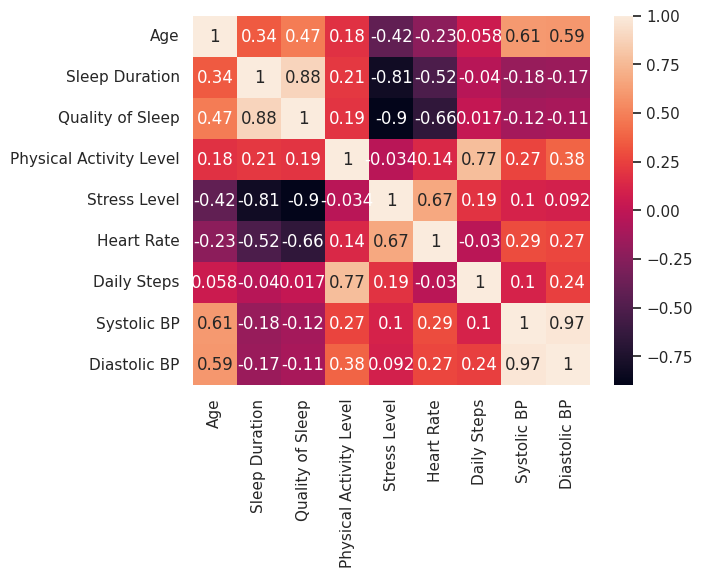

In [ ]:
sns.heatmap(Sleep.corr(numeric_only = True), annot = True)


Some things immediately pop out to me:
- It seems like Age and Blood Pressure are positively correlated, which would make sense since as one gets older, they tend to have higher blood pressure.
  - *We noticed beforehand that the distribution of Systolic BP and Diastolic BP were not similar, but this heatmap indicates that they are nearly perfectly correlated. This highlights the importance of using multiple metrics to gain insight on our data.*

- Physical Activity Level (in minutes) and Daily Steps are also positively correlated.

- The biggest inference we can make is that high Stress Levels are detremental to Quality of Sleep and Sleep Duration.

There are a few more relationships we can infer from this dataset. Take a look yourself and see what you can find.

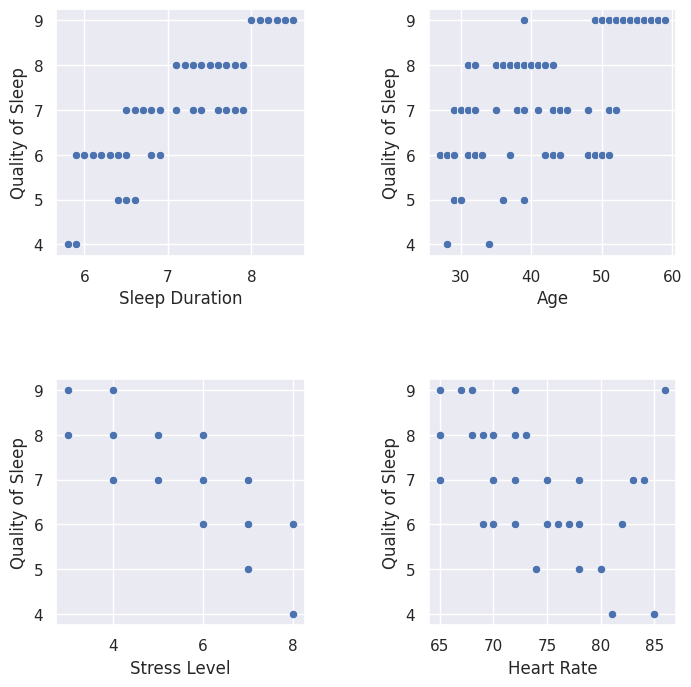

In [ ]:
categories = ["Sleep Duration", "Age", "Stress Level", "Heart Rate"]
fig, axs = plt.subplots(2,2, figsize = (8,8))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
for idx, cat in enumerate(categories):
  ax = sns.scatterplot(data = Sleep,
                       x = cat,
                       y = "Quality of Sleep",
                       ax = axs[int(idx/2), idx%2])


#Preparing our Data

In [ ]:
y, X = dmatrices("Q('Quality of Sleep') ~ Q('Sleep Duration')*Q('Stress Level')*Q('Heart Rate')-Q('Sleep Duration'):Q('Heart Rate') - Q('Sleep Duration'):Q('Stress Level'):Q('Heart Rate')", data = Sleep)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [ ]:
y, X = dmatrices("Quality of Sleep ~ Sleep Duration + Stress Level +Q('Heart Rate')-Q('Sleep Duration'):Q('Heart Rate') - Q('Sleep Duration'):Q('Stress Level'):Q('Heart Rate')", data = Sleep)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((299, 6), (75, 6), (299, 1), (75, 1))

In [ ]:
reg = sm.OLS(y, X).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Q('Quality of Sleep')   R-squared:                       0.920
Model:                               OLS   Adj. R-squared:                  0.919
Method:                    Least Squares   F-statistic:                     844.2
Date:                   Thu, 21 Sep 2023   Prob (F-statistic):          3.82e-199
Time:                           20:49:49   Log-Likelihood:                -125.55
No. Observations:                    374   AIC:                             263.1
Df Residuals:                        368   BIC:                             286.7
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                               -11.1590      1.542     -7.236      0.000     -14.191      -8.126
Q('Sleep Duration')                       1.4897      0.085     17.458      0.000       1.322       1.657
Q('Stress Level')                         3.3035      0.297     11.110      0.000       2.719       3.888
Q('Sleep Duration'):Q('Stress Level')    -0.1760      0.016    -11.008      0.000      -0.207      -0.145
Q('Heart Rate')                           0.1378      0.018      7.774      0.000       0.103       0.173
Q('Stress Level'):Q('Heart Rate')        -0.0341      0.003    -10.663      0.000      -0.040      -0.028
==============================================================================
Omnibus:                        3.512   Durbin-Watson:                   0.798
Prob(Omnibus):                  0.173   Jarque-Bera (JB):                3.848
Skew:                           0.089   Prob(JB):                        0.146
Kurtosis:                       3.464   Cond. No.                     3.69e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
preds = reg.predict(X_test)
meanSS = ((preds - y_test)**2).mean()
np.sqrt(meanSS)

array(1.69256673)

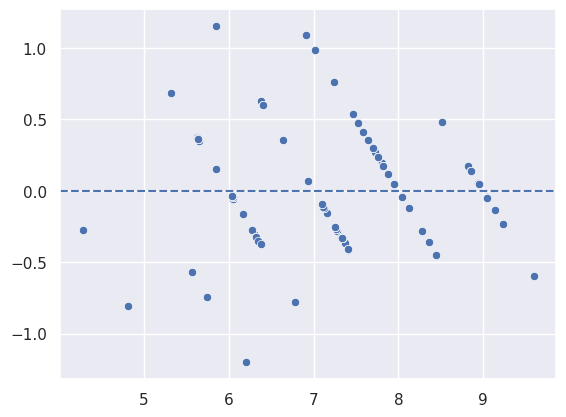

In [ ]:
sns.scatterplot(x = reg.fittedvalues, y = reg.resid)
plt.axhline(0, ls = '--')

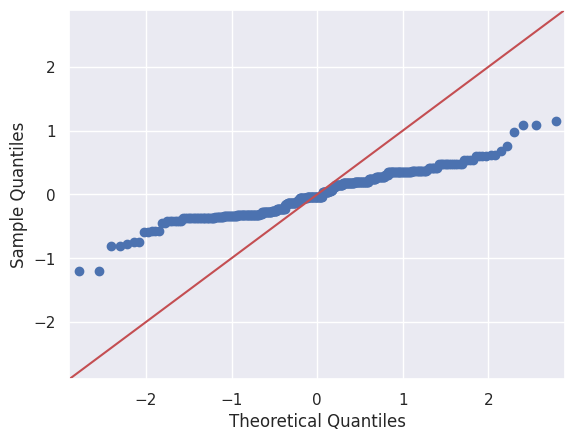

In [ ]:
sm.qqplot(reg.resid, line = '45');

In [ ]:
reg.resid

array([-0.16300661,  0.35137518,  0.35137518, -0.2740964 , -0.2740964 ,
       -0.2740964 ,  0.68627717, -0.3676311 , -0.3676311 , -0.3676311 ,
       -0.31551109, -0.3676311 , -0.31551109, -0.30735991, -0.30735991,
       -0.30735991, -0.56703519, -0.30735991, -0.56703519, -0.28092139,
       -0.32427624, -0.32427624, -0.32427624, -0.32427624, -0.3676311 ,
       -0.41098595, -0.3676311 , -0.41098595, -0.41098595, -0.41098595,
       -0.74308852, -0.74308852, -0.35832987, -0.04549611, -0.32427624,
       -0.04549611, -0.04549611, -0.28092139, -0.28092139, -0.28092139,
       -0.32427624, -0.32427624, -0.32427624, -0.3676311 , -0.32427624,
       -0.3676311 , -0.32427624, -0.3676311 , -0.32427624, -0.32427624,
       -0.44947501, -0.44947501, -0.03734493, -0.28092139, -0.03734493,
       -0.03734493, -0.32427624, -0.03734493, -0.03734493, -0.32427624,
       -0.03734493, -0.03734493, -0.05364729, -0.05364729, -0.05364729,
       -0.05364729,  0.75890034, -0.03734493, -0.27316032, -0.27